# Circuit Composition 

We develop a suite of analyses that will be used to validate the composition 
of cortical circuits built at the Blue Brain Project.


# *Data, Models, and Tests*

In this section we present how to build a brain circuit analysis using *DMT*,
out extensive analysis framework. You can read about the philosophy and 
essential concepts behind *DMT* in another notebook.

In [8]:
import numpy as np
import pandas as pd
from neuro_dmt.analysis.circuit import BrainCircuitAnalysis
from neuro_dmt.models.bluebrain.circuit.model import BlueBrainCircuitModel
from neuro_dmt.models.bluebrain.circuit.adapter import BlueBrainCircuitAdapter

('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'roi', 'mtype', 'etype', 'synapse_class', 'postsynaptic', 'presynaptic')
('region', 'layer', 'depth', 'height', 'mesocolumn', 'hypercolumn', 'roi')


In [9]:
adapter = BlueBrainCircuitAdapter()
adapter.field_dict

{'bounding_box_size': array([50., 50., 50.]),
 'logger': <dmt.tk.journal.logger.Logger at 0x11f0a93d0>,
 'sample_size': 20}

For the analysis suite, we can define components that will be common to all the
analyses we will collect in the suite.

The reference data we will use for validating the circuit consists of experimental
measurements made for each of the 6 cortical layers. Accordingly, we will make
measurements of the composition of the model circuit by layer.

For example, we will be computing several circuit composition phenomena by 
cortical layer.

In [10]:
from dmt.tk.parameters import Parameters

cortical_layers = [
    "L{}".format(layer)
    for layer in range(1, 7)
]
sscx_sub_regions = [
    "S1HL", "S1FL", "S1Sh", "S1Tr"
]
regions_and_layers = Parameters(
    pd.DataFrame({
        "region": [
            region
            for _ in cortical_layers
            for region in sscx_sub_regions],
        "layer": [
            layer
            for layer in cortical_layers
            for _ in sscx_sub_regions],
    })
)

For our analyses, we will plot model measurements along with reference data.
We will plot bars against layers for each of the 4 somatosensory cortex
sub-regions. 
Our predefined plotters allow us to do this quite conveniently.

In [11]:
from dmt.tk.plotting import Bars
from dmt.tk.plotting.multi import MultiPlot

def get_plotter(phenomenon): 
    return MultiPlot(
        mvar="region",
        plotter=Bars(
            xvar="layer",
            xlabel="Layer",
            yvar=phenomenon.label,
            ylabel=phenomenon.name,
            gvar="dataset")
    )

We have utility classes to provide an analysis report. 
Since all the analyses in our suite will be on the same circuit,
we can define a method to produce reports from analysis data,
and include circuit meta-data in this method.

In [12]:
from neuro_dmt.analysis.reporting import CircuitAnalysisReport

def circuit_analysis_report(**analysis_data):
    """
    Create a report for the data.
    """
    return CircuitAnalysisReport(
        animal="Wistar Rat",
        age="P12",
        brain_region="SSCx",
        uri="MockBlueBrainCircuitModel",
        **analysis_data
    )

We have validation reference data for cell densities and inhibitory cell ratios.
This data is from the somatosensory cortex hind-limb measured for each layer
in six individual rats. Since the same data was used to create cell density for 
all 4 sub-regions, we will use the same data to validate all 4 regions. To make
the data usable with our pre-defined analysis tool-chain, we define dataframes
with a column containing the region.

In [13]:
from dmt.data.observation import measurement
from neuro_dmt.data import rat

def _with_sscx_subregions(
    reference_dataframe):
    """
    Insert a column for SSCx subregion s.
    """
    return pd.concat([
        reference_dataframe.reset_index(
        ).assign(
            region=region
        ).set_index(
            ["region", "layer"]
        ) for region in sscx_sub_regions
    ])
cell_density_reference_data ={
    "DeFelipe2017": _with_sscx_subregions(
        rat.defelipe2017.summary_measurement.samples(1000)),
    "DeFelipe2014": _with_sscx_subregions(
        rat.defelipe2014.summary_measurement.samples(1000)),
    "meyer2010": _with_sscx_subregions(
        rat.meyer2010.samples(1000))
}

Our reference data now looks like,

In [14]:
cell_density_reference_data["DeFelipe2017"].head()

cell_density
region layer              
S1HL   L1     16892.919334
       L1      6170.822556
       L1     12483.923177
       L1     20591.316330
       L1     15564.028031

With the parameters, plotters, and reporters defined above, we can compose an
analysis.

In [15]:
from dmt.tk.phenomenon import Phenomenon
from neuro_dmt.analysis.circuit.composition.interfaces import\
    CellDensityAdapterInterface

cell_density_phenomenon = Phenomenon(
    "Cell Density",
    "Number of cells in a unit mm^3 volume.",
    group="Composition"
)
cell_density_analysis = BrainCircuitAnalysis(
    phenomenon=cell_density_phenomenon,
    AdapterInterface = CellDensityAdapterInterface,
    reference_data = cell_density_reference_data,
    measurement_parameters = regions_and_layers,
    plotter = get_plotter(cell_density_phenomenon),
    report = circuit_analysis_report
)

We can define other analyses in the same way, by just changing analysis 
components. 

In [16]:
class InhbitoryCellFractionAnalysisAdapterInterface(
    CellDensityAdapterInterface
):
    """
    Document circuit model adapter method to compute inhibitory cell fraction.
    """
    
    __measurement__ = "inhibitory_cell_fraction"
    
    def get_inhibitory_cell_fraction(self,
        circuit_model,
        **query):
        """
        The query may contain keys specifying the region in the circuit
        where the inhibitory cell fraction should be calculated.
        """
        pass

In [17]:
inhibitory_cell_fraction_phenomenon = Phenomenon(
    "Inhibitory Cell Fraction",
    "Fraction of inhibitory cells in a circuit.",
    group="Composition"
)

inhibitory_cell_fraction_reference_data ={
    "Ghobril2012": _with_sscx_subregions(rat.ghobril2012.samples(1000)),
    "LeFort2009": _with_sscx_subregions(rat.lefort2009.samples(1000)),
    "Beaulieu1992": _with_sscx_subregions(rat.beaulieu1992.samples(1000))
}
inhibitory_cell_fraction_analysis = BrainCircuitAnalysis(
    phenomenon = inhibitory_cell_fraction_phenomenon,
    AdapterInterface = InhbitoryCellFractionAnalysisAdapterInterface,
    reference_data = inhibitory_cell_fraction_reference_data,
    measurement_parameters = regions_and_layers,
    plotter = get_plotter(inhibitory_cell_fraction_phenomenon),
    report = circuit_analysis_report
)

We can use the analyses defined above to analyze any circuit
built at the BBP. We start by analyzing a mock circuit that /programmatically/
behaves exactly the same as a /real/ Blue Brain Project circuit model.

# Mock circuit
For developing our suite of analyses we will use a mock for the circuits built 
at BBP.


In [18]:
from neuro_dmt.models.bluebrain.circuit.mock.test.mock_circuit_light import\
    circuit_composition,\
    circuit_connectivity
from neuro_dmt.models.bluebrain.circuit.mock.circuit\
    import MockBlueBrainCircuitModel
mock_circuit_model = MockBlueBrainCircuitModel(
    circuit_composition,
    circuit_connectivity)

We can run our analysis step by step, first getting a measurement, and then
passing the result to the plotter.
Our adapter computes cell density in randomly sampled region of interest (ROI),
with the shape of cuboids. We can pass the number of ROIs to sample.


# Running an analyses

While we have define two analyses, and we also have a circuit to analyze, we 
also need an *object* that adapts the circuit model such that analyses we have
defined can run with them. We will use the adapter we have already developed.
You may read about this adapter in another notebook.

The adapter provides documentation

In [19]:
adapter = BlueBrainCircuitAdapter()
print(adapter.get_cell_density.__method__)


    Exhaustive Methodology
        Count of cells in all the voxcells confirming to a cell-query was divided by the total volume of these voxcells.
    Random Sampling Methodology
        Cells were counted in a box with sides of dimensions {bounding_box_size} um. Each cube was centered at a cell that was randomly sampled from  a population described by a cell-query.
    


The cell density measurement computed above is for the model circuit.
To analyze this measurement with the reference data, we need to append
reference data.

In [20]:
adapter = BlueBrainCircuitAdapter()
cell_density_measurement =\
    cell_density_analysis.get_measurement(
        mock_circuit_model,
        adapter,
        sample_size=10
)

In [21]:
cell_density_measurement["data"].head()

cell_density
dataset                   region layer              
MockBlueBrainCircuitModel S1HL   L1         416000.0
                                 L1         184000.0
                                 L1          80000.0
                                 L1           8000.0
                                 L1         208000.0

In [22]:
cell_density_analysis_data ={
    "MockBlueBrainCircuitModel": cell_density_measurement["data"]
}
cell_density_analysis_data.update(
    cell_density_reference_data
)
cell_density_measurement.keys()

dict_keys(['data', 'method'])

We can look at the statistical summary of the measurement.

For comparison against experimental data,
we consider the experimental data as *statistical models* with a mean 
and standard deviation of cell density per layer.
We use a normal statistical model to generate *samples* of cell density
measurements from the experimental data.

In [ ]:
measurement.concat_as_summaries(cell_density_analysis_data).head()

The analysis produces figures using the plotters we have defined.

In [ ]:
cell_density_figures =\
    cell_density_analysis.plotter.get_figures(
        cell_density_analysis_data,
        caption="Cell density by layer for sub-regions of the Rat SSCx"
)

We can call our analysis class can run the whole analyses.

In [ ]:
cell_density_analysis_report =\
    cell_density_analysis(
        mock_circuit_model,
        adapter
    )

The cell density analysis report generated above contains figures for each of the
SSCx sub-regions.

In [ ]:
cell_density_analysis_report.figures

In the `BlueBrainCircuitAdapter` we have documented how the cell densities were
measured, which is used along with the *phenomenon* analyzed to provide content
in the report.

In [ ]:
print(cell_density_analysis_report.introduction)

In [ ]:
print(cell_density_analysis_report.methods)

We have defined reporters to post the report as an HTML to a hard-disk.

In [44]:
import os
from neuro_dmt.analysis.reporting import CheetahReporter

reporter =\
    CheetahReporter(
        path_output_folder=os.path.join(os.getcwd(), "validations")
)
path_cell_density_analysis_report =\
    reporter.post(
        cell_density_analysis_report
)

NameError: name 'cell_density_analysis_report' is not defined

The report was generated at `path_report`.

In [ ]:
print(
    "Find the following in the analysis report: ",
    path_cell_density_analysis_report
)
os.listdir(path_cell_density_analysis_report)

We next consider the analysis of the fraction of inhibitory cells in each layer.

In [ ]:
inhibitory_cell_fraction_measurement =\
    inhibitory_cell_fraction_analysis.get_measurement(
        mock_circuit_model,
        adapter
)

In [ ]:
inhibitory_cell_fraction_measurement["data"].head()

In [ ]:
inhibitory_cell_fraction_analysis_report =\
    inhibitory_cell_fraction_analysis(
        mock_circuit_model,
        adapter
)

In [ ]:
path_inhibitory_cell_fraction_analysis_report =\
    reporter.post(
        inhibitory_cell_fraction_analysis_report
)

In [ ]:
path_inhibitory_cell_fraction_analysis_report

Cell density analyses developed above were one of the simplest.
In rest of the notebook we develop analyses of incrementing complexity,
This will also allow us to present different analyses tools also available
as part of *DNT*.


# Cell Density by *mtype* and layer.

We need to define measurement parameters that contain mtypes from circuit.


In [26]:
mtypes = adapter.get_mtypes(mock_circuit_model)
mtypes_regions_and_layers = Parameters(
    pd.DataFrame({
        "region": [
            region
            for region in sscx_sub_regions
            for _ in cortical_layers
            for _ in mtypes],
        "layer": [
            layer
            for _ in sscx_sub_regions
            for layer in cortical_layers
            for _ in mtypes],
        "mtype": [
            mtype 
            for _ in sscx_sub_regions
            for _ in cortical_layers
            for mtype in mtypes]
    })
)

In [27]:
mtype_cell_density_analysis = BrainCircuitAnalysis(
    phenomenon=cell_density_phenomenon,
    AdapterInterface = CellDensityAdapterInterface,
    measurement_parameters = mtypes_regions_and_layers,
    plotter = MultiPlot(
        mvar="mtype",
        plotter=Bars(
            xvar="layer",
            xlabel="Layer",
            yvar=cell_density_phenomenon.label,
            ylabel=cell_density_phenomenon.name,
            gvar="region")),
    report = circuit_analysis_report
)

In [28]:
mrlfs = mtypes_regions_and_layers.for_sampling(2)
adapter.visible_voxels._hashable(mrlfs[0])

(('layer', 'L1'), ('mtype', 'L1_DAC'), ('region', 'S1HL'))

In [29]:
mtype_cell_density_measurement =\
    mtype_cell_density_analysis.get_measurement(
        mock_circuit_model,
        adapter,
        sample_size=10)

In [30]:
cell_density_measurement["data"].shape, mtype_cell_density_measurement["data"].shape

((240, 1), (4560, 1))

In [31]:
mtype_cell_density_measurement["data"].head()

cell_density
dataset                   region layer mtype               
MockBlueBrainCircuitModel S1HL   L1    L1_DAC      616000.0
                                       L1_DAC      760000.0
                                       L1_DAC      448000.0
                                       L1_DAC      288000.0
                                       L1_DAC      408000.0

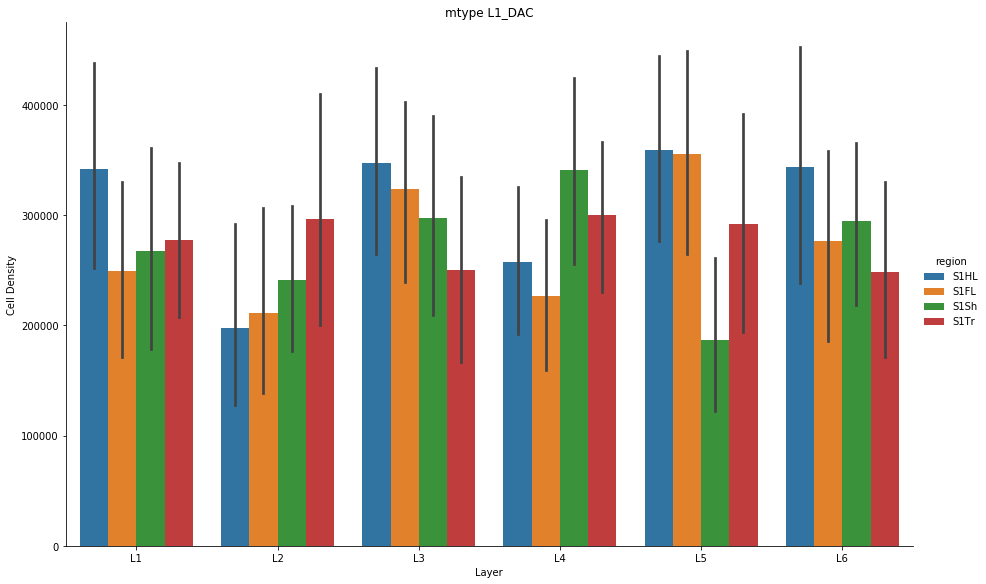

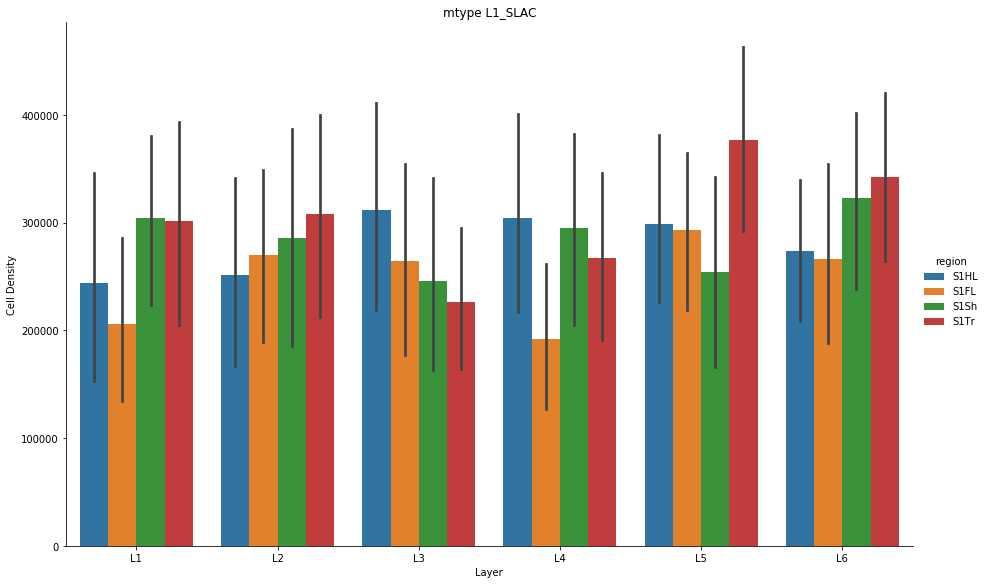

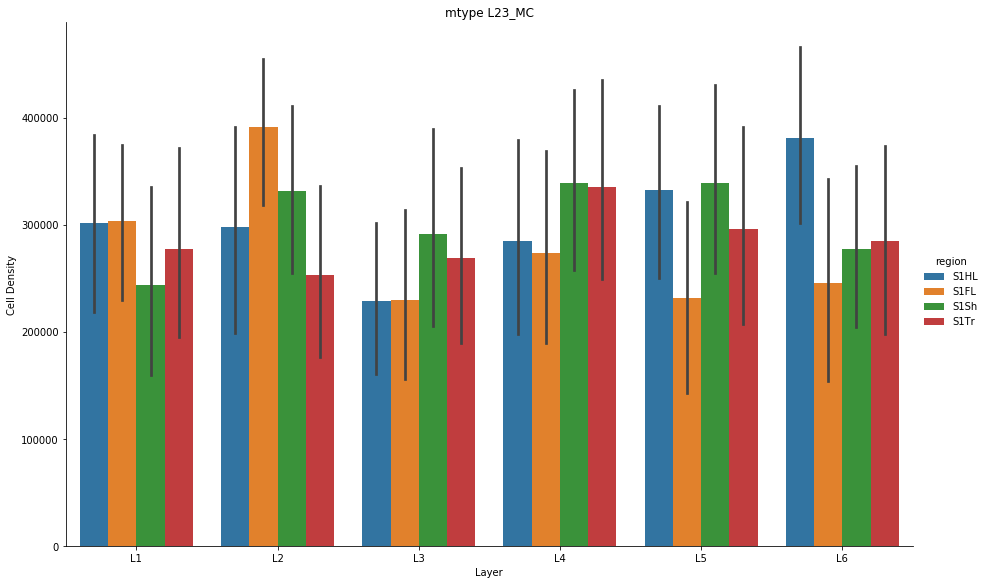

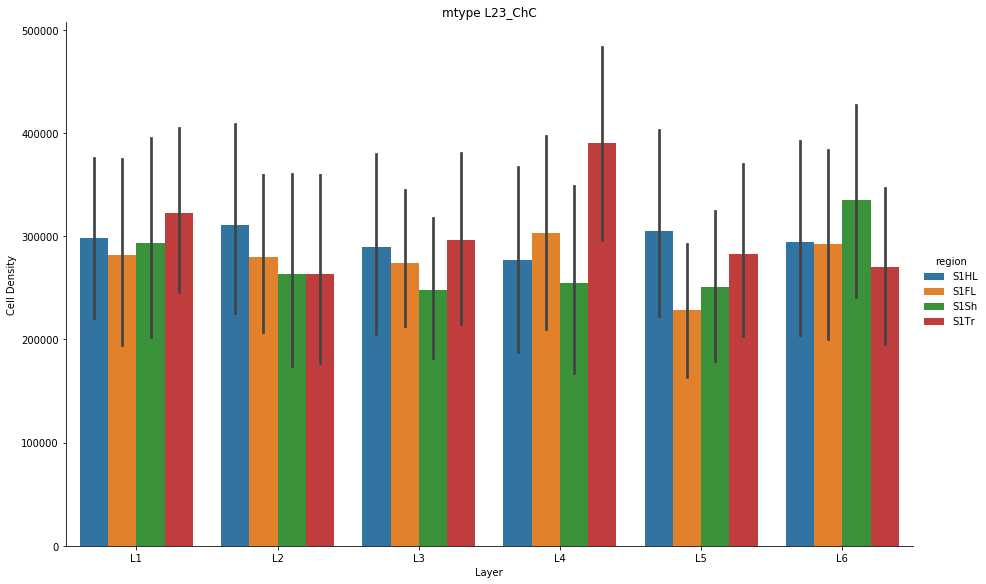

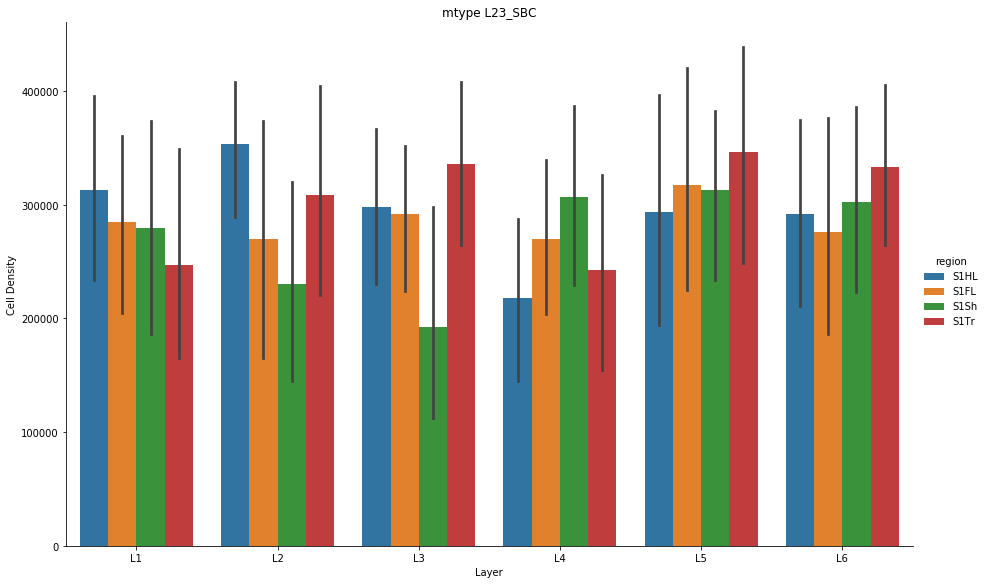

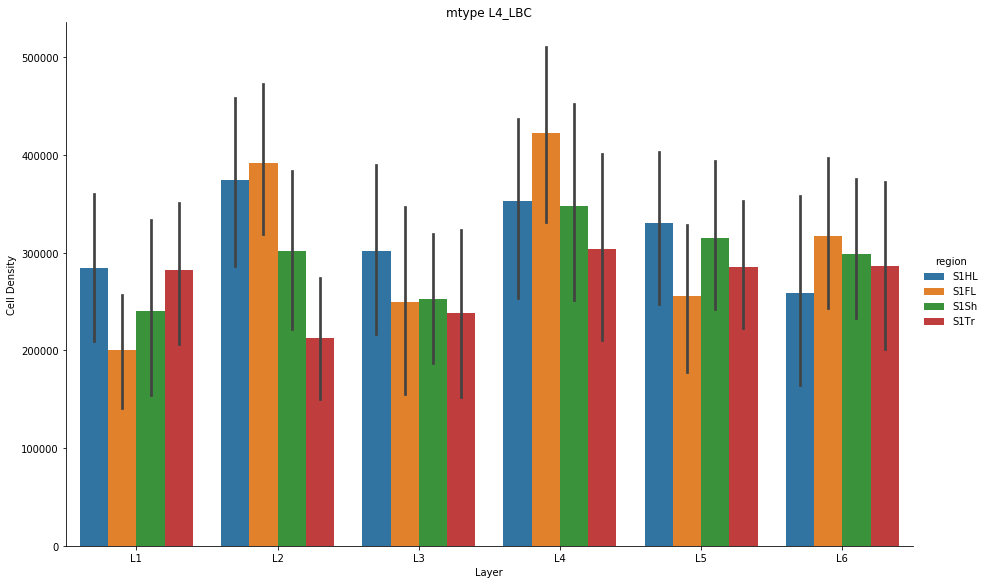

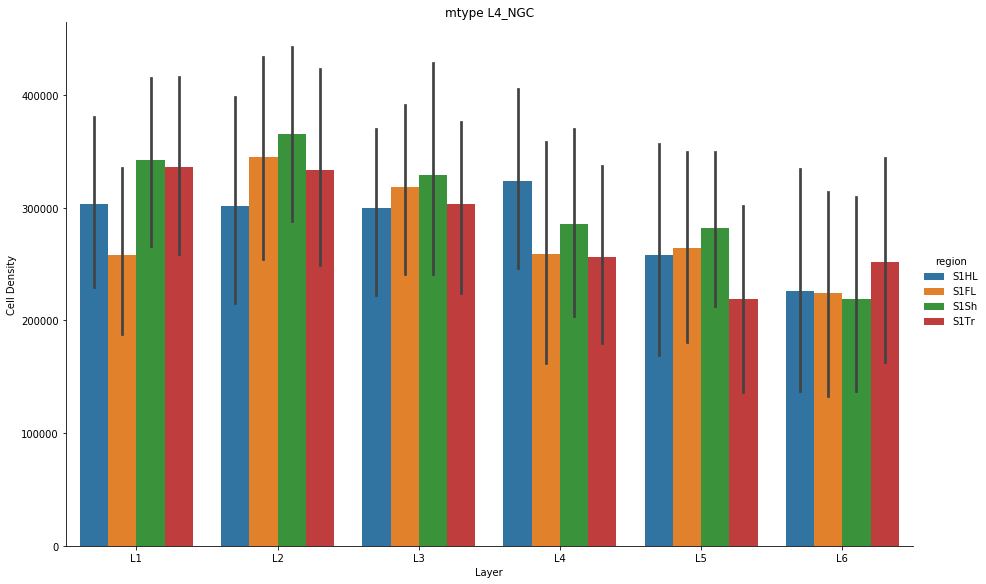

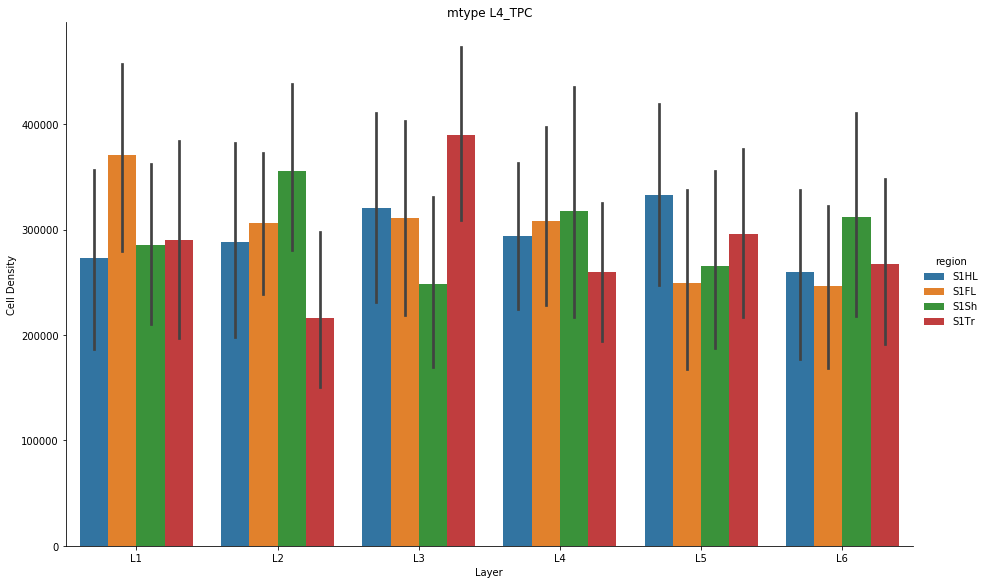

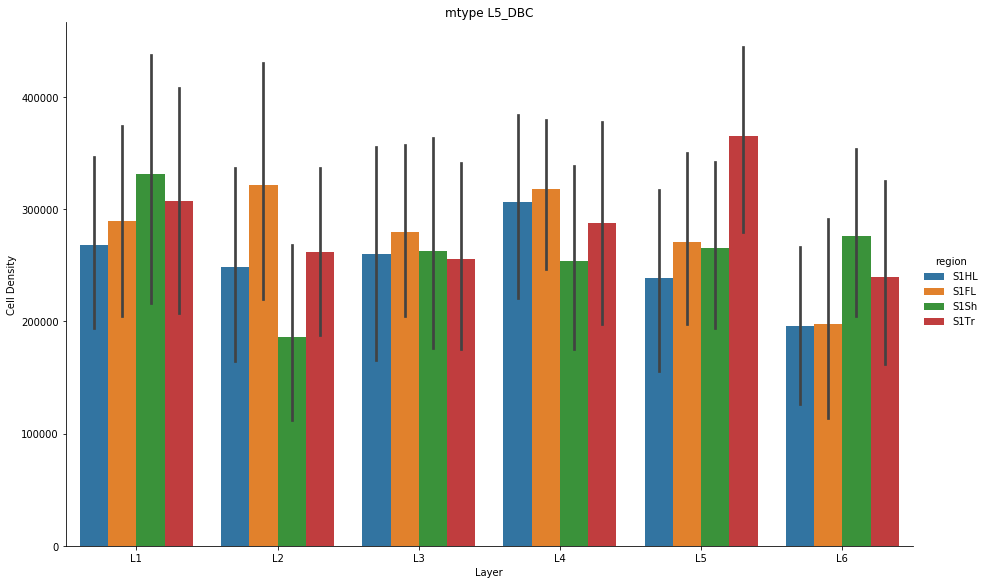

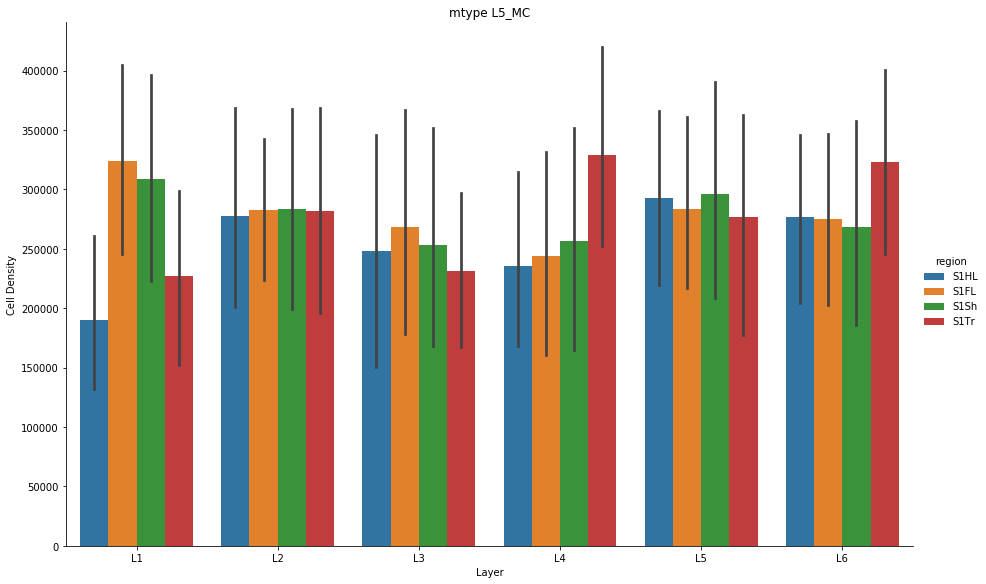

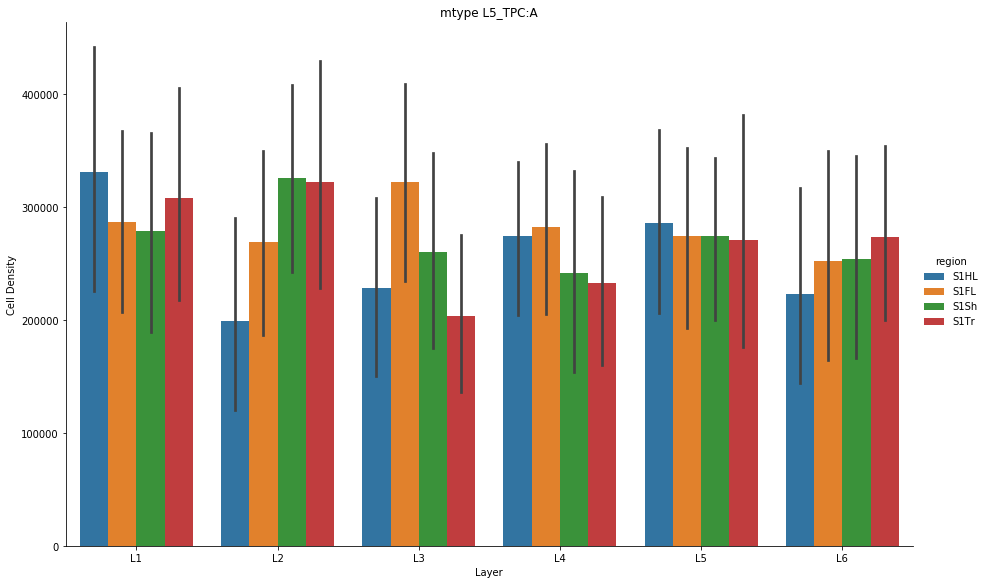

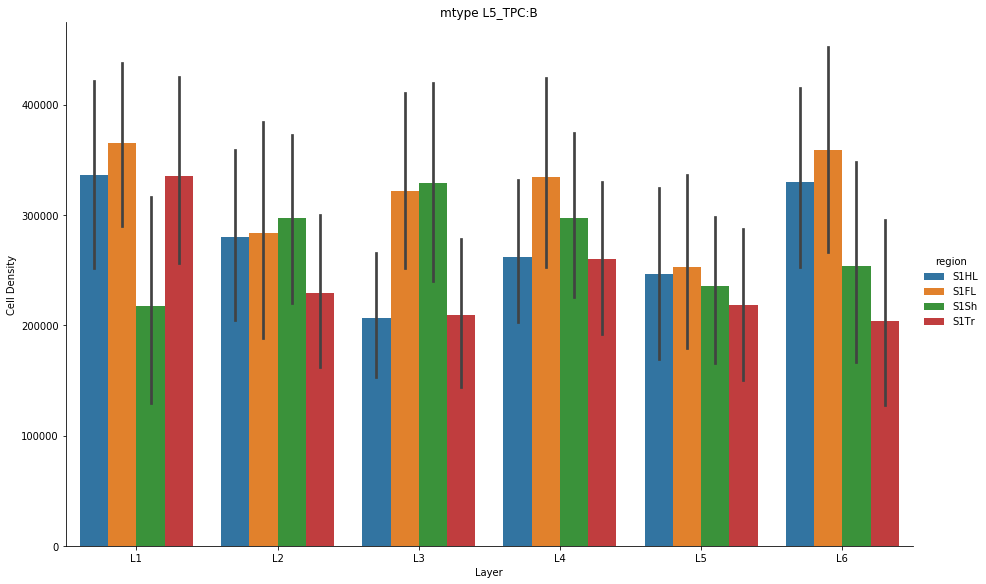

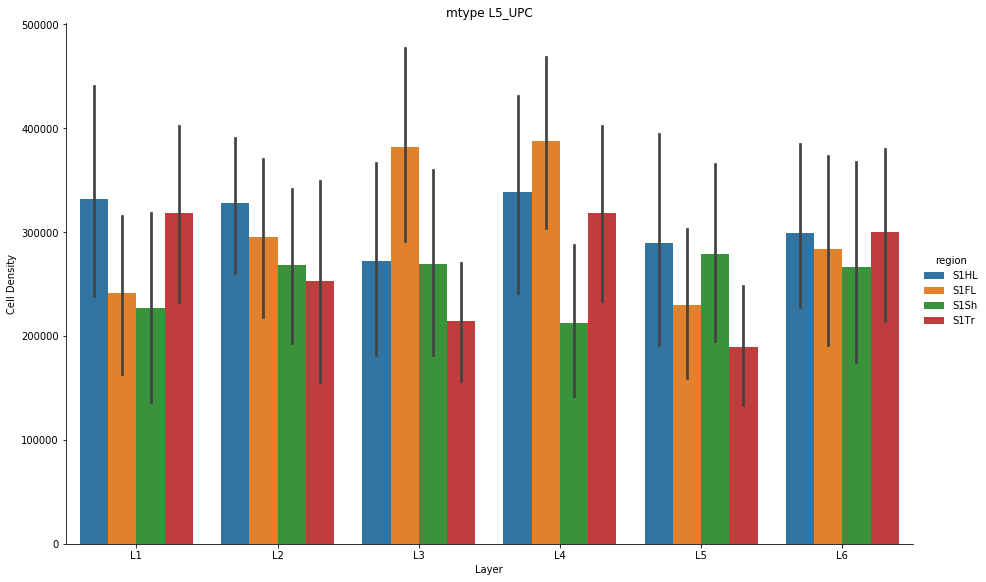

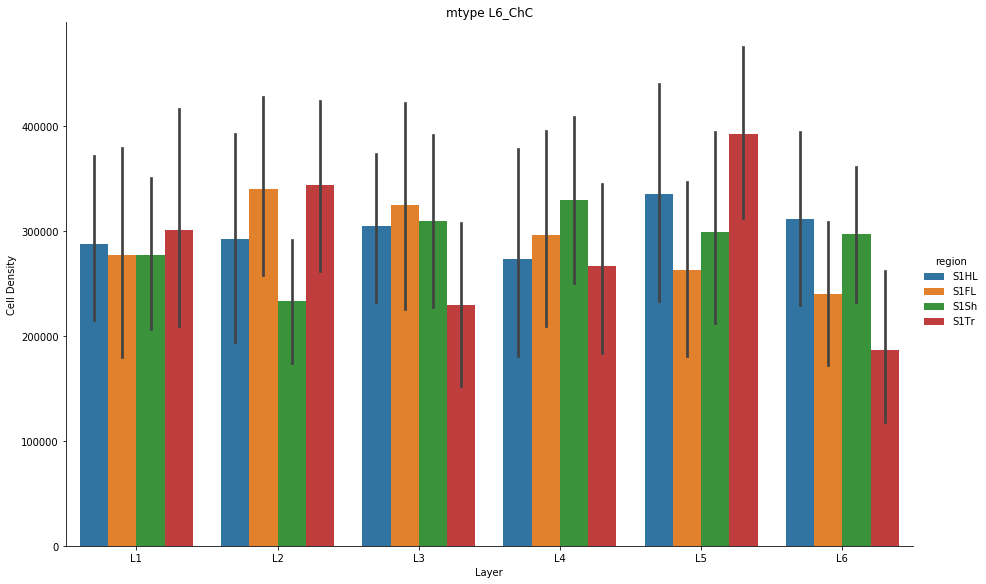

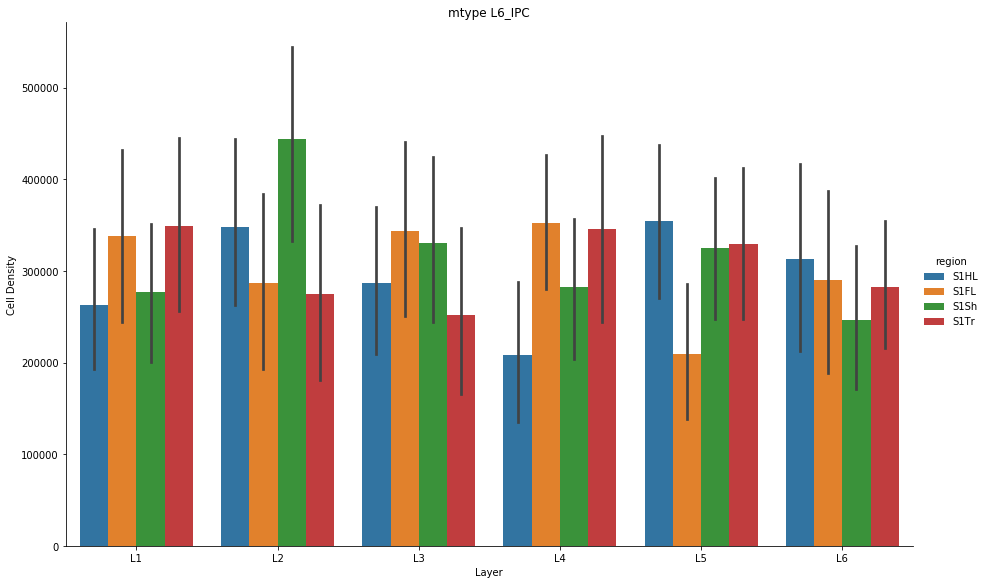

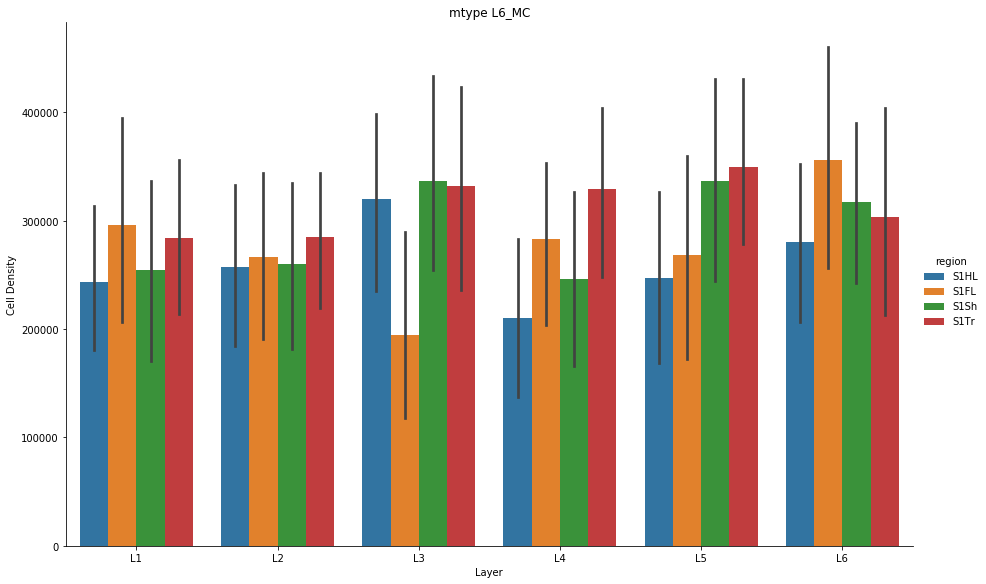

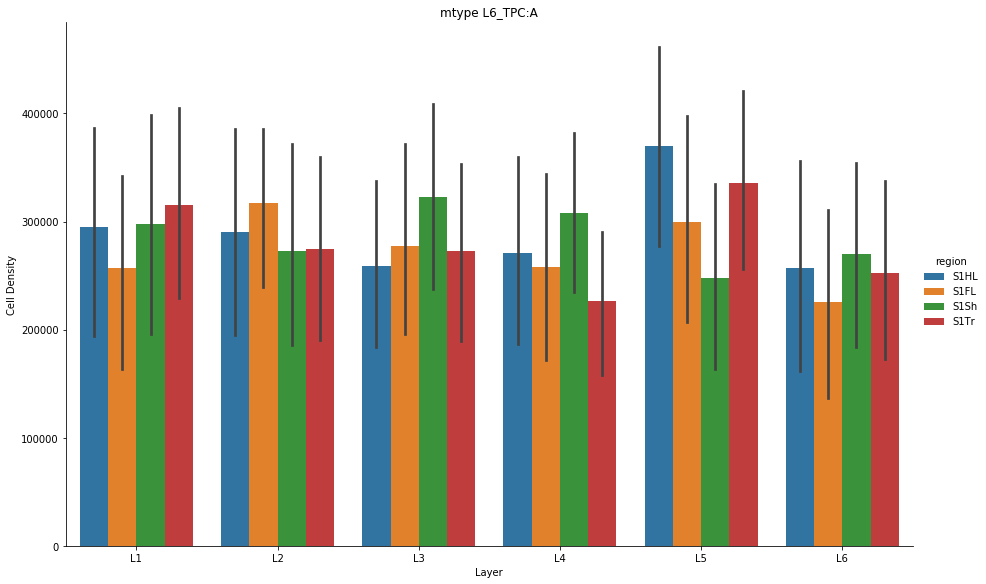

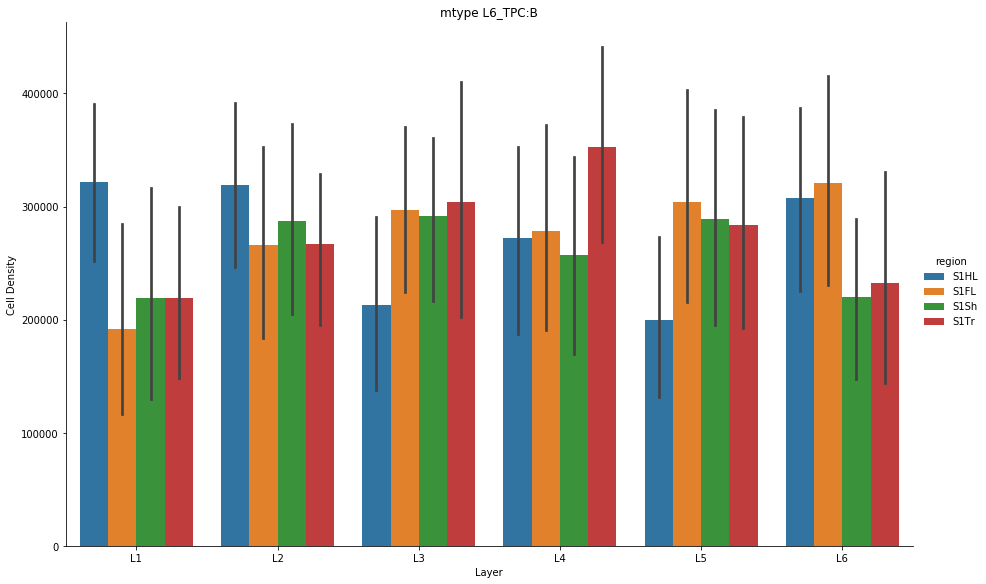

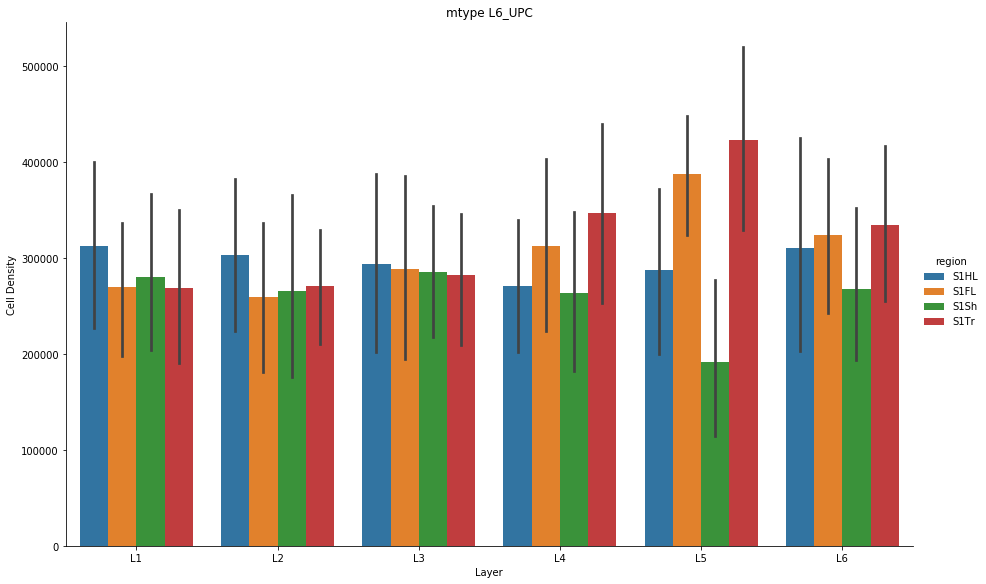

In [32]:
mtype_cell_density_analysis_report =\
    mtype_cell_density_analysis(
        mock_circuit_model,
        adapter
)

In [45]:
path_mtype_cell_density_analysis_report =\
    reporter.post(
        mtype_cell_density_analysis_report
)

In [46]:
path_mtype_cell_density_analysis_report

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/validations/cell_density/20191203/184333'

# Cell density by *mytpe*, and cortical depth

The next complexity we will add to our composition analyses is the cell density
at a given depth in the circuit.

For an atlas based circuit, cortical depth in one column may not map onto the
same *depth value* in another column. We circumvent this problem by using the
the *principal-axis* of each atlas voxel. The user, of course, does not see 
any of the detail. 

To obtain cell density in a circuit model at a given depth bin,


In [33]:
adapter.get_cell_density(mock_circuit_model, depth=np.array([0., 100.]))

24000.0

is all. To build out analyses of cell density with depth, all we need is the
measurement parameters.

In [34]:
depths = Parameters(
    pd.DataFrame({
        ("depth", "begin"): np.linspace(0, 2500, 51),
        ("depth", "end"): np.linspace(0, 2500, 51) + 50.
    }))
depths.values.head()

depth       
   begin    end
0    0.0   50.0
1   50.0  100.0
2  100.0  150.0
3  150.0  200.0
4  200.0  250.0

In [35]:
dfs = depths.for_sampling(None, None, 2)
dfs[0]

{'depth': {'begin': 0.0, 'end': 50.0}}

In [36]:
from dmt.tk.plotting import LinePlot

cell_density_by_depth_analysis =\
    BrainCircuitAnalysis(
        phenomenon=cell_density_phenomenon,
        AdapterInterface = CellDensityAdapterInterface,
        measurement_parameters = depths,
        plotter=LinePlot(
            xvar=("depth", "begin"),
            xlabel="Cortical Depth",
            yvar=cell_density_phenomenon.label,
            ylabel=cell_density_phenomenon.name,
            drawstyle="steps-mid"),
        report = circuit_analysis_report
    )

In [37]:
cell_density_by_depth_measurement =\
    cell_density_by_depth_analysis.get_measurement(
        mock_circuit_model,
        adapter
)
cell_density_by_depth_measurement["data"].head()

cell_density
dataset                   (depth, begin) (depth, end)              
MockBlueBrainCircuitModel 0.0            50.0              176000.0
                                         50.0              112000.0
                                         50.0               72000.0
                                         50.0               48000.0
                                         50.0              232000.0

In [38]:
cell_density_by_depth_measurement["data"].reset_index().head()

,dataset,"(depth, begin)","(depth, end)",cell_density
0,MockBlueBrainCircuitModel,0.0,50.0,176000.0
1,MockBlueBrainCircuitModel,0.0,50.0,112000.0
2,MockBlueBrainCircuitModel,0.0,50.0,72000.0
3,MockBlueBrainCircuitModel,0.0,50.0,48000.0
4,MockBlueBrainCircuitModel,0.0,50.0,232000.0


In [39]:
line_plotter =\
    cell_density_by_depth_analysis.plotter
line_plotter.get_dataframe(
    cell_density_by_depth_measurement["data"]
).tail()

,dataset,"(depth, begin)","(depth, end)",cell_density
1015,MockBlueBrainCircuitModel,2500.0,2550.0,24000.0
1016,MockBlueBrainCircuitModel,2500.0,2550.0,392000.0
1017,MockBlueBrainCircuitModel,2500.0,2550.0,128000.0
1018,MockBlueBrainCircuitModel,2500.0,2550.0,232000.0
1019,MockBlueBrainCircuitModel,2500.0,2550.0,456000.0


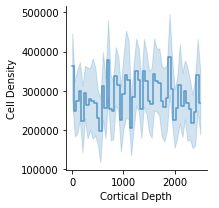

In [40]:
cell_density_by_depth_analysis_report =\
    cell_density_by_depth_analysis(
        mock_circuit_model,
        adapter)

In [47]:
path_cell_density_by_analysis_report=\
    reporter.post(
        cell_density_by_depth_analysis_report
)

In [ ]:
defelipe_data =\
    rat.defelipe2017\
    .data\
    .groupby(
        "layer"
        ).agg(
        ["mean", "std"]
        ).assign(
            normalized_thickness=lambda df: (
                df.thickness["mean"] / df.thickness["mean"].sum())
        ).assign(
            depth=lambda df: np.cumsum(df.normalized_thickness)
        )

In [ ]:
1. - defelipe_data["depth"]

In [ ]:
from dmt.data.observation import measurement

measurement.Measurement.load(
    cell_density_by_depth_measurement["data"]
)

In [42]:
adapter.visible_voxels.store

{<neuro_dmt.models.bluebrain.circuit.mock.circuit.MockBlueBrainCircuitModel at 0x11f055c90>: {(('layer',
    'L1'),
   ('region',
    'S1HL')): <neuro_dmt.models.bluebrain.circuit.adapter.query.SpatialQueryData at 0x114101490>,
  (('layer', 'L1'),
   ('region',
    'S1FL')): <neuro_dmt.models.bluebrain.circuit.adapter.query.SpatialQueryData at 0x11ef70410>,
  (('layer', 'L1'),
   ('region',
    'S1Sh')): <neuro_dmt.models.bluebrain.circuit.adapter.query.SpatialQueryData at 0x11ef70ad0>,
  (('layer', 'L1'),
   ('region',
    'S1Tr')): <neuro_dmt.models.bluebrain.circuit.adapter.query.SpatialQueryData at 0x11efac490>,
  (('layer', 'L2'),
   ('region',
    'S1HL')): <neuro_dmt.models.bluebrain.circuit.adapter.query.SpatialQueryData at 0x11efa59d0>,
  (('layer', 'L2'),
   ('region',
    'S1FL')): <neuro_dmt.models.bluebrain.circuit.adapter.query.SpatialQueryData at 0x11ef68610>,
  (('layer', 'L2'),
   ('region',
    'S1Sh')): <neuro_dmt.models.bluebrain.circuit.adapter.query.SpatialQueryDa

In [41]:
assert adapter.visible_voxels._hashed({"depth": {"begin": 100., "end": 200.}})\
     != adapter.visible_voxels._hashed({"depth": {"begin": 0., "end": 100.}})

In [ ]:
 def _hashable(xs):
    """
    Get hash for a query.
    """
    try:
        _ = hash(xs)
        return xs
    except TypeError:
        return ';'.join(str(x) for x in xs)
    raise RuntimeError(
        "Execution of _hashed(...) should not reach here.")


In [ ]:
_hashable({"begin": 0., "end": 100.})

In [ ]:
from dmt.tk.collections.data import make_hashable
assert hash(make_hashable({"begin": 0., "end": 100.}))\
    != hash(make_hashable({"begin": 100., "end": 200.}))

In [ ]:
make_hashable({"ah": "bah", "gah": "mah"})

In [ ]:

make_hashable({"gah": "mah", "ah": "bah"})

In [ ]:
sorted(tuple({3:4, 1:2}.items()), key=lambda kv: kv[0])

In [ ]:
make_hashable({"ah": {1:2}, "bah": {"gah": "jaja"}})

In [ ]:
from collections import OrderedDict

isinstance(OrderedDict(), dict)

In [ ]:
from frozendict import FrozenOrderedDict

isinstance(FrozenOrderedDict(), dict)

In [ ]:
FrozenOrderedDict(OrderedDict(sorted({9:4, 6:7}.items(), key=lambda kv: kv[0])))

In [49]:
import seaborn


In [53]:
import pandas
import matplotlib.pyplot as plt
import seaborn
from dmt.tk.utils.string_utils import make_name
from dmt.tk.field import Field, LambdaField, lazyfield, WithFields
from dmt.data.observation import measurement
from dmt.tk.plotting import golden_aspect_ratio
from dmt.tk.plotting.figure import Figure



class LinePlot(WithFields):
    """
    Define the requirements and behavior of a line plot.
    """
    xvar = Field(
        """
        Column in the data-frame to be plotted along the x-axis.
        """)
    yvar= Field(
        """
        Column in the data-frame to be plotted along the y-axis.
        """)
    gvar = Field(
        """
        Geometry Variable: column in the dataframe that will be plotted as
        different geometries (i.e. lines for `LinePlot`).
        A default value of empty string will be interpreted as not set,
        and hence there will be only a single line in the plot.
        """,
        __default_value__="")
    fvar = Field(
        """
        Facet Variable: Column in the dataframe that will be plotted on several
        faces. A default value of empty string will be interpreted as not set,
        and hence there will be only one face in the figure.
        """,
        __default_value__="")
    xlabel = LambdaField(
        """
        The label to be displayed along the y-axis.
        Default value of an empty string will cause `xvar` to be displayed.
        """,
        lambda self: self.xvar)
    ylabel = LambdaField(
        """
        The label to be displayed along the y-axis.
        Default value of an empty string will cause `yvar` to be displayed.
        """,
        lambda self: self.yvar)
    height_figure = Field(
        """
        Height of the figure.
        """,
        __default_value__=12.)
    aspect_ratio_figure = Field(
        """
        Aspect ratio width / height for the figure.
        """,
        __default_value__=golden_aspect_ratio)
    number_columns = LambdaField(
        """
        Number of columns in the figure.
        """,
        lambda self: None if not self.fvar else 3)
    drawstyle = Field(
        """
        Specify how to draw the lines that join the (x, y) points.
        Default value join the points with simple points. Other possibilities
        are steps.
        """,
        __default_value__="default")

    def get_dataframe(self, data, dataset=None):
        """
        Extract the dataframe to plot.
        """
        if dataset:
            raise NotImplementedError(
            """
                `LinePLot.get_figure(...)` current version does not support
                argument `dataset`.
                """)
        if isinstance(data, (pandas.Series, pandas.DataFrame)):
            return data.reset_index()
        return measurement.concat_as_samples(data).reset_index()

    def get_figure(self,
            data,
            *args,
            dataset=None,
            caption="Caption not provided"):
        """
        Plot the data.

        Arguments
        -------------
        data : Either a dataframe or a dict mapping dataset to dataframe.
        dataset : dataset or list of dataset names whose data will be plotted.
        """
        def _make_name(label):
            return make_name(
                '_'.join(label) if isinstance(label, tuple) else label,
                separator='_')

        grid = seaborn\
            .FacetGrid(
                self.get_dataframe(data, dataset),
                col=self.fvar if self.fvar else None,
                hue=self.gvar if self.gvar else None,
                col_wrap=self.number_columns,
                height=self.height_figure,
                aspect=self.aspect_ratio_figure,
                legend_out=True)
        grid.map(
            seaborn.lineplot,
            self.xvar,
            self.yvar,
            drawstyle=self.drawstyle,
            alpha=0.7
        ).set_titles(
            _make_name(self.fvar) + "\n{col_name} "
        ).add_legend(
            title=_make_name(self.gvar))
        return Figure(
            grid.set(
                xlabel=self.xlabel,
                ylabel=self.ylabel),
            caption=caption)

    def plot(self,
            *args, **kwargs):
        """
        Plot the data

        Arguments
        -----------
        data : A dict mapping dataset to dataframe.
        """
        return self.get_figure(*args, **kwargs)

    def __call__(self,
            data):
        """
        Make this class a callable,
        so that it can masquerade as a function!

        Arguments
        -----------
        data : A dict mapping dataset to dataframe.
        """
        return self.get_figure(*args, **kwargs)


In [54]:
line_plot = LinePlot(
    xvar=("depth", "begin"),
    xlabel="Cortical Depth",
    yvar=cell_density_phenomenon.label,
    ylabel=cell_density_phenomenon.name,
    drawstyle="steps-mid")

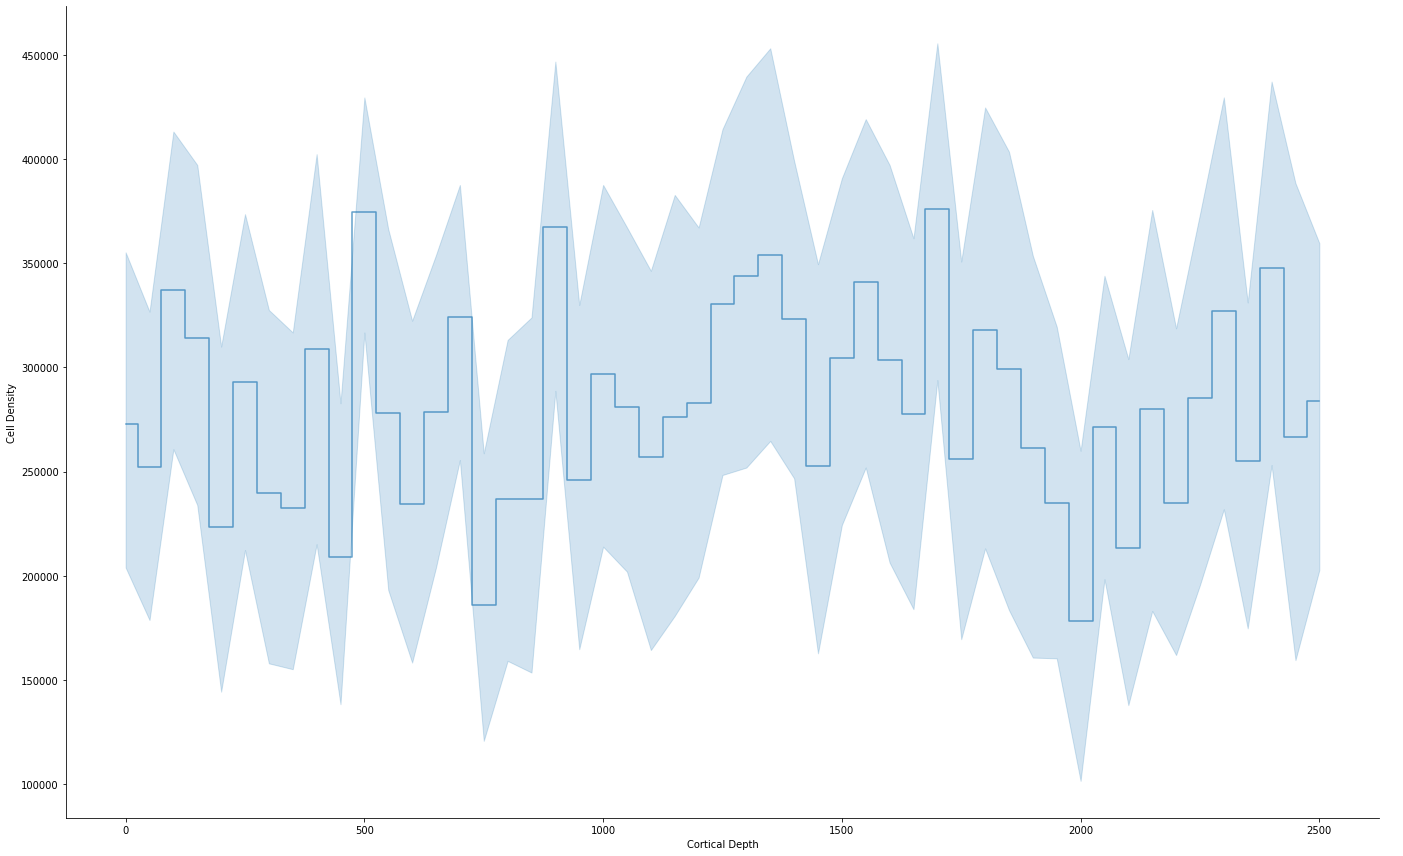

In [55]:
line_plot.get_figure(cell_density_by_depth_measurement["data"])